In [1]:
from collections import defaultdict
import minorminer.layout as mml
import minorminer as mm
import dwave_networkx as dnx
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pymetis

# Partitioning

In [2]:
class Partition():
    def __init__(self, G, k):
        self.G = G
        self.k = k
    
    def partition_graph(self):
        _, partition = pymetis.part_graph(self.k, self.G)

        vtx_partition = defaultdict(list)
        for i, part in enumerate(partition):
            vtx_partition[part].append(i)
        
        self.Q = nx.quotient_graph(self.G, vtx_partition.values())
        return self.Q

    def inverse_subgraph_nhbd(self, V):
        # It's a list if it comes from the target graph T
        if isinstance(V, list):
            N_Q = []
            for v in V:
                N_Q += list(self.Q.neighbors(v))
            X_G = nx.Graph(self.G.subgraph([x for X in V for x in X]).edges())
        else:
            N_Q = list(self.Q.neighbors(V))
            X_G = nx.Graph(self.G.subgraph(V).edges())
        
        for a in list(X_G.nodes):
            N_a = set(self.G[a])
            for B in N_Q:
                if not set(B).isdisjoint(N_a):
                    X_G.add_edge(a, B)
        
        return X_G, frozenset(N_Q)

In [39]:
S = nx.random_regular_graph(3, 120)
T = dnx.chimera_graph(8)

## Partition S and T down

In [40]:
P_S, P_T = Partition(S, 5), Partition(T, 64)

In [41]:
Q_S = P_S.partition_graph()

In [42]:
Q_T = P_T.partition_graph()

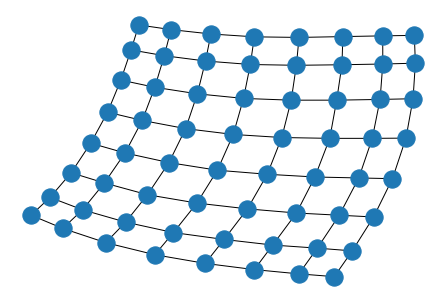

In [43]:
nx.draw(Q_T)

(True, <networkx.algorithms.planarity.PlanarEmbedding object at 0x11aa7c210>)


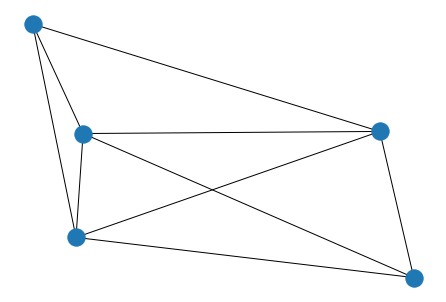

In [44]:
print(nx.check_planarity(Q_S))
nx.draw(Q_S)

## Get a loose bound on the number of unit tiles required for each part

In [45]:
needs = {}
for V in Q_S:
    test_emb = {}
    for i in range(1,5):
        for j in range(i, 5):
            test_emb = mm.find_embedding(S.subgraph(V), dnx.chimera_graph(i, j))
            if test_emb:
                needs[V] = f"{i}x{j}"
                break
        if test_emb:
            break

In [48]:
for v, need in needs.items():
    print(len(v), need)

24 2x2
24 2x2
24 2x2
24 2x2
24 2x2


## Embed the partitioned graph of S in the partitioned graph of T

In [49]:
emb, success = mm.find_embedding(Q_S, Q_T, return_overlap=True)
success

1

## Compute the minor for each part

In [50]:
def neighborhood_map(V, Q, emb, N_X, N_Y):
    qubits = [x for X in Q for x in X]
    
    restrict_chains = {}
    for v in V:
        restrict_chains[v] = qubits
    for x in N_X:
        restrict_chains[x] = set(emb[x]) & N_Y
    
    return restrict_chains

def embed_each_part(emb, P_S, P_T):
    small_embeddings = {}
    for V, Q in emb.items():
        X, N_X = P_S.inverse_subgraph_nhbd(V)
        Y, N_Y = P_T.inverse_subgraph_nhbd(Q)
        restrict_chains = neighborhood_map(V, Q, emb, N_X, N_Y)
        small_embeddings[V] = mm.find_embedding(X, Y, restrict_chains=restrict_chains)
    return small_embeddings

In [51]:
embed_each_part(emb, P_S, P_T)

{frozenset({0,
            5,
            13,
            15,
            16,
            17,
            20,
            32,
            39,
            40,
            41,
            45,
            50,
            61,
            67,
            75,
            78,
            88,
            94,
            100,
            104,
            109,
            110,
            112}): {},
 frozenset({1,
            6,
            7,
            25,
            44,
            47,
            51,
            54,
            55,
            57,
            59,
            65,
            66,
            69,
            70,
            72,
            82,
            92,
            96,
            98,
            103,
            105,
            107,
            116}): {},
 frozenset({2,
            10,
            22,
            27,
            28,
            29,
            34,
            36,
            42,
            46,
            52,
            62,
            63,
         

# Pegasus

In [142]:
H = dnx.pegasus_graph(5, nice_coordinates=True)
L = mml.dnx_layout(H)

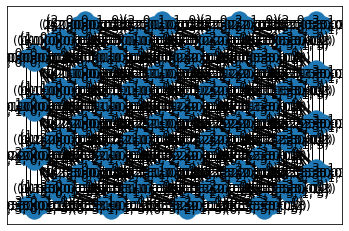

In [143]:
nx.draw_networkx(H, pos=L.layout)

In [144]:
lattice = L.integer_lattice_layout()

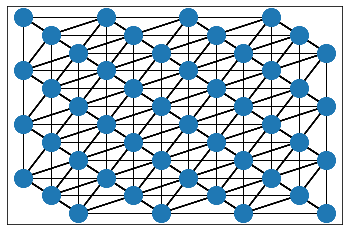

In [145]:
nx.draw_networkx(H, pos=lattice, with_labels=False)

# Binning

In [2]:
S = nx.random_regular_graph(3, 60)
T = dnx.chimera_graph(4)

In [41]:
L = mml.Layout(S)
L.kamada_kawai()
S_int_lat = L.to_integer_lattice(3)

LL = mml.Layout(T)
LL.chimera()
T_int_lat = LL.to_integer_lattice(3)

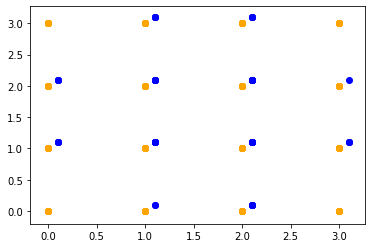

In [42]:
x = [x[0]+.1 for x in S_int_lat.values()]
y = [x[1]+.1 for x in S_int_lat.values()]
a = [x[0] for x in T_int_lat.values()]
b = [x[1] for x in T_int_lat.values()]

plt.scatter(x, y, color="blue")
plt.scatter(a, b, color="orange")
plt.show()

In [5]:
mml.find_embedding(S, T, placement=mml.placement.binning, bins=3)

{26: [120, 88],
 47: [94, 86],
 44: [56, 63],
 27: [121, 89, 124],
 39: [78],
 22: [90, 92],
 13: [85],
 17: [83, 115],
 10: [82],
 40: [93],
 56: [19, 51],
 35: [126, 118, 122],
 18: [54],
 19: [46],
 45: [62, 58],
 1: [50],
 49: [38],
 57: [40],
 34: [74, 79],
 46: [106],
 23: [91, 95, 87],
 43: [105, 108],
 31: [117, 109],
 53: [57],
 29: [61],
 0: [43, 45, 75],
 32: [9, 41],
 14: [53],
 28: [76, 84],
 36: [10, 12],
 9: [73, 77],
 25: [81, 49],
 7: [96, 103],
 41: [32, 64],
 51: [100],
 20: [111],
 5: [70],
 2: [33, 37],
 6: [2, 7, 34],
 24: [68, 65],
 3: [69, 66],
 52: [15, 23],
 21: [99, 67],
 59: [101, 97],
 48: [114],
 8: [127, 119, 123],
 12: [113, 116],
 15: [112],
 42: [14, 11],
 37: [22],
 11: [17],
 16: [29, 21],
 58: [16],
 33: [59, 27],
 50: [104, 72],
 4: [55],
 54: [60],
 38: [52, 44],
 55: [48, 80],
 30: [47, 42]}